# LUNG NODULE IDENTIFICATION

### Pre-Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rawpy
import os
import numpy as np
#import skimage.io as io
import SimpleITK as sltk
import matplotlib.animation as animation
import imageio
import cv2
from IPython.display import Image
import warnings
import multiprocessing
import glob
import random
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import warnings

#from skimage import measure, morphology
#from skimage.transform import resize

from keras.models import Model
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, merge
from keras.optimizers import Adam
from keras import backend as K
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import SpatialDropout3D
from keras.layers import BatchNormalization
from keras.models import load_model

Using TensorFlow backend.


#### Nodule Annotation File

In [3]:
df1=pd.read_csv('D:/Data Science Bowl 2017/LUNA Dataset/CSVFILES/annotations.csv')

#### Resampling image to isometric form

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)! A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 
<br> -  [1] https://www.kaggle.com/akh64bit/full-preprocessing-tutorial; <br> -  [2] https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

The chest scans are produced by a variety of CT scanners, this causes a difference in spacing between voxels of the original scan. We rescaled and interpolated all CT scans so that each voxel represents a 1x1x1 mm cube. <br> -  [3] https://eliasvansteenkiste.github.io/machine%20learning/lung-cancer-pred/

In [4]:
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [int(np.round(original_size[0]*(original_spacing[0]/out_spacing[0]))),
                int(np.round(original_size[1]*(original_spacing[1]/out_spacing[1]))),
                int(np.round(original_size[2]*(original_spacing[2]/out_spacing[2])))]

    resample = sltk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sltk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sltk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sltk.sitkBSpline)

    return resample.Execute(itk_image)

In [5]:
slice_size=64
number_of_slices_per_scan=12
batch_size=1
v_batch_size=1

#### Files Location

In [6]:
#Create a list of all CT scans in a folder
L=[]
for i in range(0,10):
    M=[]
    M=glob.glob('D:/Data Science Bowl 2017/LUNA Dataset/subset'+str(i)+'/subset'+str(i)+'/*.mhd')
    L=L+M
len(L)

888

In [7]:
def dice_coef(y_true, y_pred):
    smooth = .000000001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.abs(K.sum(y_true_f * y_pred_f))
    return (2. * intersection+smooth) / (K.abs(K.sum(y_true_f)) + K.abs(K.sum(y_pred_f)) + smooth)
#Remove smooth from numerator

In [8]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [9]:
def recall_metric(y_true, y_pred):
    smooth = .000000001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.abs(K.sum(y_true_f * y_pred_f))
    recall = (intersection+smooth) / (K.abs(K.sum(y_true_f)) + smooth)
    return recall

In [10]:
#Numbers below gets divided everytime we apply maxpooling; this can create issue when concatenating two models
NUM_SLIDES=slice_size
IMG_HEIGHT=slice_size
IMG_WIDTH=slice_size
IMG_CHANNELS=1

In [11]:
# Build U-Net model
inputs = keras.layers.Input((NUM_SLIDES,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = keras.layers.Lambda(lambda x: x / 3095)(inputs)
 
c1 = keras.layers.Conv3D(16, kernel_size=(3,3,3), activation='relu',padding='same')(inputs)
c1 = keras.layers.SpatialDropout3D(0.3)(c1)
c1 = keras.layers.Conv3D(16, (3,3,3), activation='relu',padding='same')(c1)
#GlobalAveragePooling3D -- try this as well
p1 = keras.layers.MaxPooling3D((2,2,2))(c1)
p1 = BatchNormalization()(p1)
 
c2 = keras.layers.Conv3D(32, (3,3,3), activation='relu',padding='same')(p1)
c2 = keras.layers.SpatialDropout3D(0.3)(c2)
c2 = keras.layers.Conv3D(32, (3,3,3), activation='relu',padding='same')(c2)
p2 = keras.layers.MaxPooling3D((2,2,2))(c2)
p2 = BatchNormalization()(p2)

c3 = keras.layers.Conv3D(64, (3,3,3), activation='relu',padding='same')(p2)
c3 = keras.layers.SpatialDropout3D(0.3)(c3)
c3 = keras.layers.Conv3D(64, (3,3,3), activation='relu',padding='same')(c3)
p3 = keras.layers.MaxPooling3D((2, 2,2))(c3)
p3 = BatchNormalization()(p3)

c4 = keras.layers.Conv3D(128, (3,3,3), activation='relu',padding='same')(p3)
c4 = keras.layers.SpatialDropout3D(0.3)(c4)
c4 = keras.layers.Conv3D(128, (3,3,3), activation='relu', padding='same')(c4)
p4 = keras.layers.MaxPooling3D(pool_size=(2,2,2))(c4)
p4 = BatchNormalization()(p4)

c5 = keras.layers.Conv3D(256, (3,3,3), activation='relu',padding='same')(p4)
c5 = keras.layers.SpatialDropout3D(0.3)(c5)
c5 = keras.layers.Conv3D(256, (3,3,3), activation='relu', padding='same')(c5)
p5 = keras.layers.MaxPooling3D(pool_size=(2,2,2))(c5)
p5 = BatchNormalization()(p5)


c55 = keras.layers.Conv3D(512, (3,3,3), activation='relu',padding='same')(p5)
c55 = keras.layers.SpatialDropout3D(0.3)(c55)
c55 = keras.layers.Conv3D(512, (3,3,3), activation='relu',padding='same')(c55)
c55 = BatchNormalization()(c55)


u66 = keras.layers.Conv3DTranspose(256, (2,2,2), strides=(2,2,2), padding='same')(c55)
u66 = keras.layers.concatenate([u66, c5])
c66 = keras.layers.Conv3D(256, (3,3,3), activation='relu',padding='same')(u66)
c66 = keras.layers.SpatialDropout3D(0.3)(c66)
c66 = keras.layers.Conv3D(256, (3,3,3), activation='relu',padding='same')(c66)
c66 = BatchNormalization()(c66)

u6 = keras.layers.Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(c66)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv3D(128, (3,3,3), activation='relu',padding='same')(u6)
c6 = keras.layers.SpatialDropout3D(0.3)(c6)
c6 = keras.layers.Conv3D(128, (3,3,3), activation='relu',padding='same')(c6)
c6 = BatchNormalization()(c6)

u7 = keras.layers.Conv3DTranspose(64, (2, 2,2), strides=(2, 2,2), padding='same')(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv3D(64, (3, 3,3), activation='relu',padding='same')(u7)
c7 = keras.layers.SpatialDropout3D(0.3)(c7)
c7 = keras.layers.Conv3D(64, (3, 3,3), activation='relu',padding='same')(c7)
c7 = BatchNormalization()(c7)

u8 = keras.layers.Conv3DTranspose(32, (2, 2,2), strides=(2, 2,2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv3D(32, (3, 3,3), activation='relu',padding='same')(u8)
c8 = keras.layers.SpatialDropout3D(0.3)(c8)
c8 = keras.layers.Conv3D(32, (3, 3,3), activation='relu',padding='same')(c8)
c8 = BatchNormalization()(c8)

u9 = keras.layers.Conv3DTranspose(16, (2, 2,2), strides=(2, 2,2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1], axis=4)
c9 = keras.layers.Conv3D(16, (3, 3,3), activation='relu',padding='same')(u9)
c9 = keras.layers.SpatialDropout3D(0.3)(c9)
c9 = keras.layers.Conv3D(16, (3, 3,3), activation='relu',padding='same')(c9)
c9 = BatchNormalization()(c9)
 
outputs = keras.layers.Conv3D(1, (1, 1,1), activation='sigmoid')(c9)
 
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef,recall_metric])
model.summary()

W0913 11:21:17.214820 32296 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 11:21:17.233635 32296 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 11:21:17.241009 32296 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 11:21:17.258350 32296 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0913 11:21:17.265295 3229

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 64, 64, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout3d_1 (SpatialDro (None, 64, 64, 64, 1 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 64, 64, 1 6928        spatial_dropout3d_1[0][0]        
____________________________________________________________________________________________

### Mask Prediction

In [12]:
model = load_model('temp_model.h5', custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef,'recall_metric':recall_metric})

W0913 11:21:22.741552 32296 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [13]:
test_data=L[750:888]

In [14]:
def test_generator(files_path, batch_size):

    LUF = len(files_path)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < LUF:
            limit = min(batch_end, LUF)
            X = files_path[batch_start:limit]
            data_X=X.reshape(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1)
            
            yield (data_X)   

            batch_start += batch_size   
            batch_end += batch_size

In [15]:
def split_image(split_array,z,y,x,split_size):
    cropped_image=[]
    for ip in range(0,z):
        for jp in range(0,y):
            for kp in range(0,x):
                cropped_image.append(split_array[ip*split_size:(ip+1)*split_size,jp*split_size:(jp+1)*split_size,kp*split_size:(kp+1)*split_size])
    
    cropped_image=np.asarray(cropped_image)
    
    return cropped_image

In [16]:
def combine_image(split_array,z,y,x,split_size):
    AA = np.zeros((z*split_size,y*split_size,x*split_size))
    k=0
    for xu in range(0,z):
        for yu in range(0,y):
            for zu in range(0,x):
                AA[xu*split_size:(xu+1)*split_size,yu*split_size:(yu+1)*split_size,zu*split_size:(zu+1)*split_size]=split_array[k]
                k=k+1
    return AA             

In [17]:
def predict_generator_fn(test_data,batch_size,split_size):
    
    predicted_mask=[]
    
    for i in range(0,len(test_data)):
        nda0=sltk.ReadImage(test_data[i])
        nda1=resample_image(nda0)
        nda=sltk.GetArrayFromImage(nda1)
        
        z=nda.shape[0]//split_size
        y=nda.shape[1]//split_size
        x=nda.shape[2]//split_size
        
        cropped_image=split_image(nda,z,y,x,split_size)
        
        predict_array = model.predict_generator(test_generator(cropped_image,batch_size),steps = np.ceil(cropped_image.shape[0]/batch_size))
        predict_array=predict_array.reshape(predict_array.shape[0],predict_array.shape[1],predict_array.shape[2],predict_array.shape[3])
        
        temp_mask=combine_image(predict_array,z,y,x,split_size)

        predicted_mask.append(temp_mask)
        
        nda0=None
        nda1=None
        combined_mask=None
        predict_array=None
        cropped_image=None 
        temp_mask=None
        
    return predicted_mask

In [18]:
Predicted_Mask=predict_generator_fn(test_data=test_data,batch_size=10,split_size=slice_size)

#### Calculate dice coefficient on test dataset

In [19]:
def generate_test_mask(location,split_size):
    nda0=sltk.ReadImage(location)
    nda1=resample_image(nda0)
    nda=sltk.GetArrayFromImage(nda1)
    
    AA = np.zeros((nda.shape[0],nda.shape[1], nda.shape[2]),dtype=float) #z,y,x
    
    X_org=np.array(nda1.GetOrigin())[0]
    Y_org=np.array(nda1.GetOrigin())[1]
    Z_org=np.array(nda1.GetOrigin())[2]
    
    a=location.split('\\')[len(location.split('\\'))-1][:-4]
    sub_loop=len(df1[df1['seriesuid']==a])
    
    for w in range(0,sub_loop):
        radius = int(df1[df1['seriesuid']==a]['diameter_mm'].iloc[w]/2)
        x0=df1[df1['seriesuid']==a]['coordX'].iloc[w]
        y0=df1[df1['seriesuid']==a]['coordY'].iloc[w]
        z0=df1[df1['seriesuid']==a]['coordZ'].iloc[w]
       
        v_x0=int(x0-X_org)
        v_y0=int(y0-Y_org)
        v_z0=int(z0-Z_org)
            
        for x in range(v_z0-radius-1, v_z0+radius+1):
            for y in range(v_y0-radius-1, v_y0+radius+1):
                for z in range(v_x0-radius-1, v_x0+radius+1):
                    deb = radius - abs(v_z0-x) - abs(v_y0-y) - abs(v_x0-z) 
                    if (deb)>=0:
                        AA[x,y,z] = float(1.0)
    
    nda0=sltk.ReadImage(test_data[i])
    nda1=resample_image(nda0)
    nda=sltk.GetArrayFromImage(nda1)
        
    z=nda.shape[0]//split_size
    y=nda.shape[1]//split_size
    x=nda.shape[2]//split_size
    
    split_mask=split_image(AA,z,y,x,split_size)
    combined_mask=combine_image(split_mask,z,y,x,split_size)
    
    return combined_mask

In [20]:
#Calculate Dice Coefficient of Prediction
avg_dice_coefficient=[]

for i in range(0,len(Predicted_Mask)):
    y_true=generate_test_mask(test_data[i],split_size=slice_size)
    y_pred=Predicted_Mask[i]
    smooth = .000000001
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.abs((y_true_f * y_pred_f).sum())
    avg_dice_coefficient.append((2. * intersection+smooth) / (np.abs(y_true_f.sum()) + np.abs(y_pred_f.sum()) + smooth))

In [21]:
sum(avg_dice_coefficient)/len(avg_dice_coefficient)

0.015881240483331394

#### Visualize predictions!!

In [22]:
def convert_image_ndarray(location):
    nda0=sltk.ReadImage(location)
    nda1=resample_image(nda0)
    nda=sltk.GetArrayFromImage(nda1)
    return nda

In [23]:
mask_array=[]
image_arr=[]
predicted_arr=[]
    
for i in range(0,len(test_data)):
    try:
        mask_array.append(generate_test_mask(test_data[i],split_size=slice_size))
        image_arr.append(convert_image_ndarray(test_data[i]))
        predicted_arr.append(Predicted_Mask[i])
                    
    except:
        pass

In [24]:
number_plots=5
sum_nodules=[]
image_no=[]
    
for i in range(0,len(mask_array)):
    sum_nodules.append(mask_array[i].sum())
    image_no.append(i)
    
df_selected = pd.DataFrame({'a_image_no': image_no,'b_sum_nodules': sum_nodules})
df_selected.sort_values(by=['b_sum_nodules'],inplace=True,ascending=False)
df_selected=df_selected[0:number_plots]

In [25]:
z=[]
final_sum=[]

for i in range(0,number_plots):
    slide_value=[]
    z_temp=[]
    for k in range(0,mask_array[int(df_selected.iloc[i][0])].shape[0]):
        slide_value.append(mask_array[int(df_selected.iloc[i][0])][k].sum())
        z_temp.append(k)
    
    df2_temp = pd.DataFrame({'slide_value': slide_value,'z_temp': z_temp})  
    df2_temp.sort_values(by=['slide_value'],inplace=True,ascending=False)
        
    z.append(df2_temp.iloc[0][1])
    final_sum.append(mask_array[int(df_selected.iloc[i][0])][int(df2_temp.iloc[0][1])].sum())
    
df_selected['z']=z
df_selected['final_sum']=final_sum

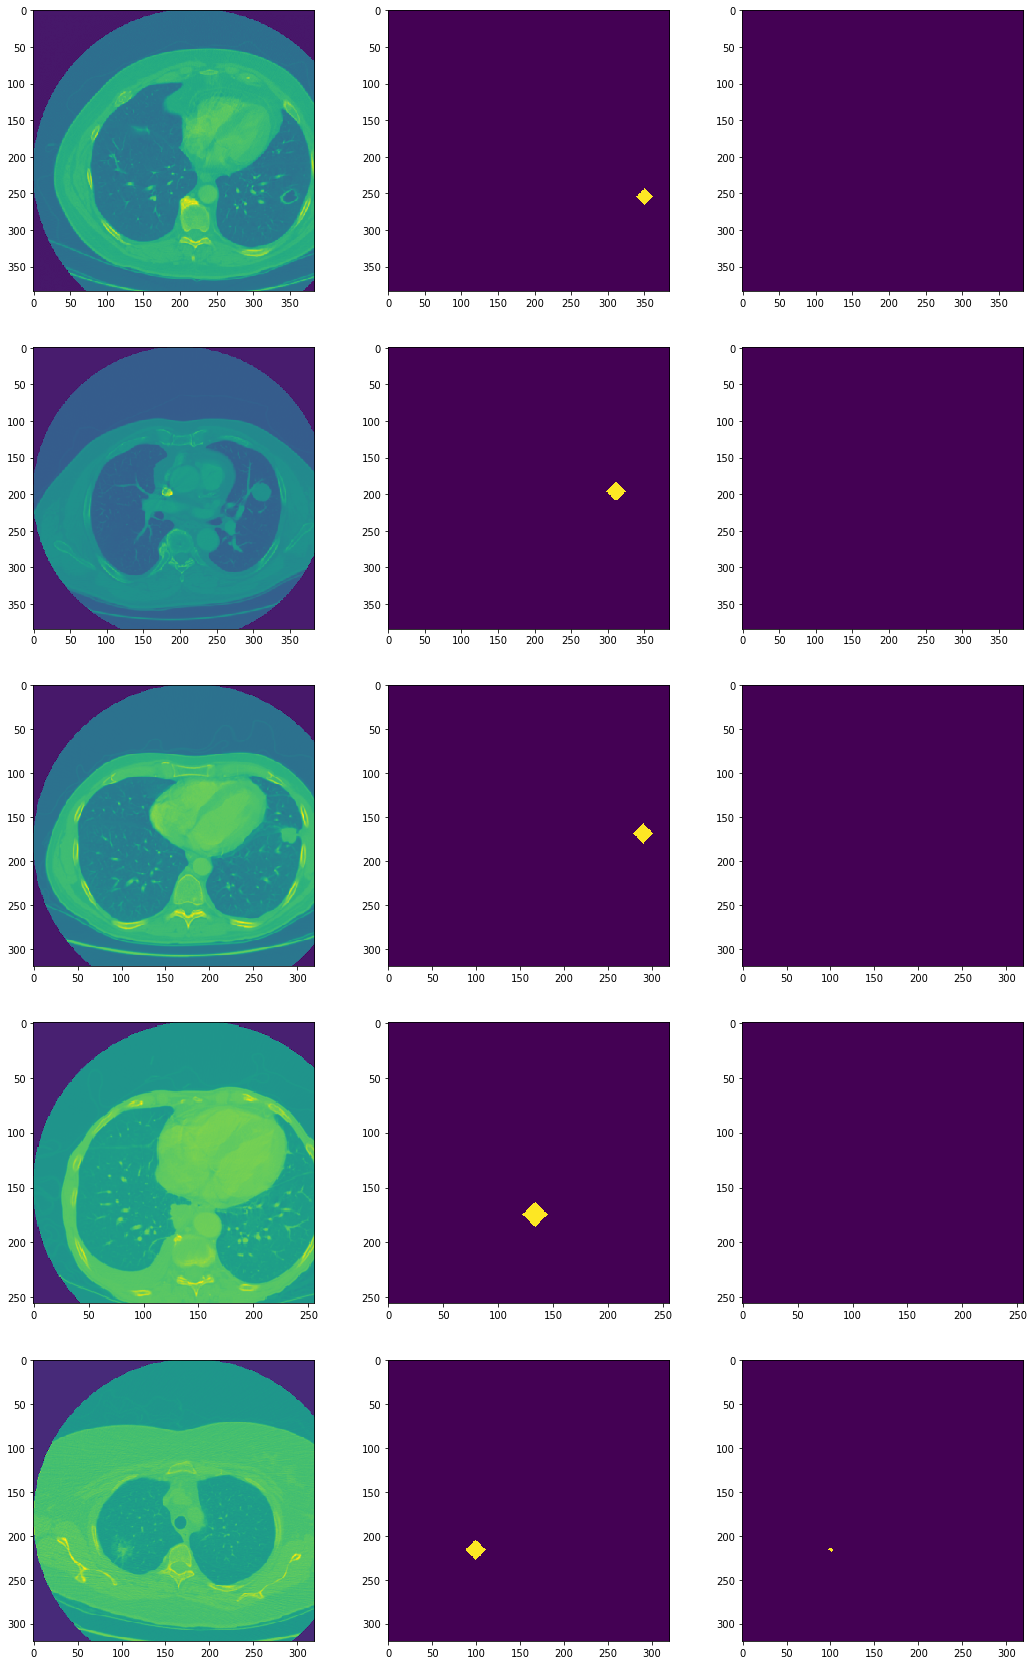

In [26]:
#Check vizually if the prediction is accurate
num_rows=number_plots
num_cols=3
height=num_rows*6
width=num_cols*6

%matplotlib inline
fig = plt.figure(figsize=(width,height))

count=0

for i in range(0,len(df_selected)):
    count=count+1
    ax = fig.add_subplot(num_rows,num_cols,count)
    #fix the size of the image to match mask and predicted mask!
    ax.imshow(image_arr[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])][0:mask_array[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])].shape[0],0:mask_array[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])].shape[1]])
    
    count=count+1
    ax = fig.add_subplot(num_rows,num_cols,count)
    ax.imshow(mask_array[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])])
    
    count=count+1
    ax = fig.add_subplot(num_rows,num_cols,count)
    ax.imshow(predicted_arr[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])])